In [1]:
!pip install -q timm
!pip install -q tensorboardX

     |████████████████████████████████| 431 kB 9.8 MB/s 
     |████████████████████████████████| 125 kB 7.9 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

# Ref: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py
# Install: pip install timm
import timm
from timm.models.efficientnet import default_cfgs 
from tensorboardX import SummaryWriter

import os
import shutil
import sys
import time
from glob import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pwd

/content


In [6]:
# !unzip "/content/drive/MyDrive/ARV_Varuna_Hackathon2022/training_data/training_data (1).zip" 

In [7]:
# len(glob("/content/training_data/train/*")), len(glob("/content/training_data/test/*"))

In [8]:
!wget "http://boatpeerawat.trueddns.com:38380/datasets/training_data_5d.zip"

--2022-06-19 15:21:05--  http://boatpeerawat.trueddns.com:38380/datasets/training_data_5d.zip
Resolving boatpeerawat.trueddns.com (boatpeerawat.trueddns.com)... 58.9.110.21
Connecting to boatpeerawat.trueddns.com (boatpeerawat.trueddns.com)|58.9.110.21|:38380... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048932963 (1000M) [application/zip]
Saving to: ‘training_data_5d.zip’

training_data_5d.zi 100%[===================>]   1000M  4.42MB/s    in 2m 23s  

2022-06-19 15:23:29 (6.99 MB/s) - ‘training_data_5d.zip’ saved [1048932963/1048932963]



In [9]:
!unzip "/content/training_data_5d.zip"

Streaming output truncated to the last 5000 lines.
  inflating: training_data_5d/train/train_0249_004_3.npy  
  inflating: training_data_5d/train/train_0249_005_3.npy  
  inflating: training_data_5d/train/train_0249_006_3.npy  
  inflating: training_data_5d/train/train_0249_007_3.npy  
  inflating: training_data_5d/train/train_0249_008_3.npy  
  inflating: training_data_5d/train/train_0249_009_3.npy  
  inflating: training_data_5d/train/train_0249_010_3.npy  
  inflating: training_data_5d/train/train_0249_011_3.npy  
  inflating: training_data_5d/train/train_0249_012_3.npy  
  inflating: training_data_5d/train/train_0249_013_3.npy  
  inflating: training_data_5d/train/train_0249_014_3.npy  
  inflating: training_data_5d/train/train_0249_015_3.npy  
  inflating: training_data_5d/train/train_0249_016_3.npy  
  inflating: training_data_5d/train/train_0249_017_3.npy  
  inflating: training_data_5d/train/train_0249_018_3.npy  
  inflating: training_data_5d/train/train_0249_019_3.npy  
  inf

In [10]:
npy_path = sorted(glob("/content/training_data_5d/train/*.npy"))
df = pd.Series(npy_path,name="npy_path").to_frame()
df['classes'] = df['npy_path'].apply(lambda x: int(x.split('.')[0][-1])-1)
df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[3])
# df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[3])
df

,npy_path,classes,area_id
0,/content/training_data_5d/train/train_0000_000...,0,0000
1,/content/training_data_5d/train/train_0001_000...,0,0001
2,/content/training_data_5d/train/train_0001_001...,0,0001
3,/content/training_data_5d/train/train_0002_000...,0,0002
4,/content/training_data_5d/train/train_0002_001...,0,0002
...,...,...,...
5914,/content/training_data_5d/train/train_1315_000...,2,1315
5915,/content/training_data_5d/train/train_1316_000...,2,1316
5916,/content/training_data_5d/train/train_1316_001...,2,1316
5917,/content/training_data_5d/train/train_1316_002...,2,1316


In [11]:
# npy_path = sorted(glob("/content/training_data/train/*.npy"))
# df = pd.Series(npy_path,name="npy_path").to_frame()
# df['classes'] = df['npy_path'].apply(lambda x: int(x.split('.')[0][-1])-1)
# df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[2])
# # df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[3])
# df

In [12]:
df['area_id'].unique()

array(['0000', '0001', '0002', ..., '1314', '1315', '1316'], dtype=object)

In [13]:
train_id,test_id = train_test_split(df['area_id'].unique(), test_size=0.1, random_state=42)

# df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)
df_train = df.loc[[(i in train_id) for i in df['area_id']]]
df_val = df.loc[[(i in test_id) for i in df['area_id']]]

df_train.shape,df_val.shape

((5446, 3), (473, 3))

In [14]:
df_train

,npy_path,classes,area_id
0,/content/training_data_5d/train/train_0000_000...,0,0000
1,/content/training_data_5d/train/train_0001_000...,0,0001
2,/content/training_data_5d/train/train_0001_001...,0,0001
3,/content/training_data_5d/train/train_0002_000...,0,0002
4,/content/training_data_5d/train/train_0002_001...,0,0002
...,...,...,...
5910,/content/training_data_5d/train/train_1312_006...,2,1312
5911,/content/training_data_5d/train/train_1313_000...,2,1313
5912,/content/training_data_5d/train/train_1314_000...,0,1314
5913,/content/training_data_5d/train/train_1314_001...,0,1314


In [16]:
df_val

,npy_path,classes,area_id
88,/content/training_data_5d/train/train_0023_000...,2,0023
110,/content/training_data_5d/train/train_0032_000...,0,0032
111,/content/training_data_5d/train/train_0032_001...,0,0032
112,/content/training_data_5d/train/train_0032_002...,0,0032
113,/content/training_data_5d/train/train_0032_003...,0,0032
...,...,...,...
5846,/content/training_data_5d/train/train_1293_003...,2,1293
5915,/content/training_data_5d/train/train_1316_000...,2,1316
5916,/content/training_data_5d/train/train_1316_001...,2,1316
5917,/content/training_data_5d/train/train_1316_002...,2,1316


In [17]:
df_train['classes'].value_counts()

0    2398
2    1913
1     577
3     558
Name: classes, dtype: int64

In [18]:
df_downsample = pd.concat([df_train[df_train['classes']==0].sample(600),df_train[df_train['classes']==2].sample(600)]+[df_train[df_train['classes']==1],df_train[df_train['classes']==3]])
df_downsample = df_downsample.sample(frac=1).reset_index(drop=True)
df_downsample['classes'].value_counts()

0    600
2    600
1    577
3    558
Name: classes, dtype: int64

In [19]:
df_downsample

,npy_path,classes,area_id
0,/content/training_data_5d/train/train_1085_000...,0,1085
1,/content/training_data_5d/train/train_0547_001...,0,0547
2,/content/training_data_5d/train/train_1306_000...,2,1306
3,/content/training_data_5d/train/train_0062_002...,0,0062
4,/content/training_data_5d/train/train_1241_003...,3,1241
...,...,...,...
2330,/content/training_data_5d/train/train_0562_006...,1,0562
2331,/content/training_data_5d/train/train_1055_004...,0,1055
2332,/content/training_data_5d/train/train_0355_009...,3,0355
2333,/content/training_data_5d/train/train_0766_000...,1,0766


In [20]:
df_upsample = pd.concat([df_train[df_train['classes']==0],df_train[df_train['classes']==2],df_train[df_train['classes']==2].sample(400)]+[df_train[df_train['classes']==1],df_train[df_train['classes']==3]]*4)
df_upsample = df_upsample.sample(frac=1).reset_index(drop=True)
df_upsample['classes'].value_counts()

0    2398
2    2313
1    2308
3    2232
Name: classes, dtype: int64

In [21]:
df_upsample

,npy_path,classes,area_id
0,/content/training_data_5d/train/train_0343_001...,1,0343
1,/content/training_data_5d/train/train_1256_034...,2,1256
2,/content/training_data_5d/train/train_0731_001...,0,0731
3,/content/training_data_5d/train/train_0683_004...,0,0683
4,/content/training_data_5d/train/train_1299_001...,2,1299
...,...,...,...
9246,/content/training_data_5d/train/train_1229_007...,1,1229
9247,/content/training_data_5d/train/train_0267_001...,1,0267
9248,/content/training_data_5d/train/train_1152_007...,0,1152
9249,/content/training_data_5d/train/train_0864_009...,2,0864


In [22]:
len(df['npy_path'])

5919

In [23]:
df['npy_path'][0]

'/content/training_data_5d/train/train_0000_000_1.npy'

In [24]:
# Dataset Loader
class SatDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.npy_path = list(df['npy_path'])
        self.label = list(df['classes'])

    def __len__(self):
        return len(self.npy_path)
    def __getitem__(self, idx):
        data = np.load(self.npy_path[idx])
        data = np.reshape(data, (-1,data.shape[2]))
        # print(data.shape)
        # data = torch.from_numpy(np.swapaxes(data, -3, -1)).float()
        data = torch.from_numpy(np.swapaxes(data, 0, 1)).float()
        # print(data.shape)
        return {'image': data, 'label': self.label[idx]}

train_dataset = SatDataset(df_upsample)
val_dataset = SatDataset(df_val)

# dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [25]:
#enumerate -> สามารถดึงลูป id ออกมาได้
for idx,batch in enumerate(train_loader):
  break
print("X Shape",batch['image'].shape)
print("y Shape",batch['label'].shape)

X Shape torch.Size([64, 60, 256])
y Shape torch.Size([64])


In [26]:
# class ClassifierModel(torch.nn.Module):
#     def __init__(self,num_class=4):
#         super(ClassifierModel, self).__init__() 
#         self.backbone = torch.nn.Sequential(
#             # torch.nn.Flatten(),
#             torch.nn.Conv2d(5, 5, kernel_size=3, padding='same', bias = False),
#             torch.nn.MaxPool2d(2),
#             torch.nn.BatchNorm2d(5),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(5, 5, kernel_size=3, padding='same', bias = False),
#             torch.nn.MaxPool2d(2),
#             torch.nn.BatchNorm2d(5),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(5, 5, kernel_size=3, padding='same', bias = False),
#             # torch.nn.BatchNorm2d(5),
#             torch.nn.MaxPool2d(2),
#             torch.nn.AvgPool2d(2),
#             # torch.nn.BatchNorm2d(15),
#             # torch.nn.LeakyReLU(),
#             # torch.nn.Conv2d(15, 18, kernel_size=3, padding='same'),
#             # torch.nn.MaxPool2d(2),
#             # torch.nn.BatchNorm2d(18),
#             # torch.nn.LeakyReLU(),
#             torch.nn.Flatten()
#             )
#         self.classifier = torch.nn.Sequential(
#             torch.nn.Linear(5*12, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Dropout(0.2),
#             # torch.nn.Linear(5*12, num_class),
#             torch.nn.Linear(16, num_class),
#             )

class ClassifierModel(torch.nn.Module):
    def __init__(self,num_class=4):
        super(ClassifierModel, self).__init__() 
        self.backbone = torch.nn.Sequential(
            # torch.nn.Flatten(),
            torch.nn.Conv1d(5, 5, kernel_size=3, padding='same', bias = False),
            torch.nn.MaxPool1d(2),
            torch.nn.BatchNorm1d(5),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(5, 5, kernel_size=3, padding='same', bias = False),
            torch.nn.MaxPool1d(2),
            torch.nn.BatchNorm1d(5),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(5, 5, kernel_size=3, padding='same', bias = False),
            # torch.nn.BatchNorm2d(5),
            torch.nn.MaxPool1d(2),
            torch.nn.BatchNorm1d(5),
            torch.nn.AvgPool1d(2),
            # torch.nn.BatchNorm2d(15),
            # torch.nn.LeakyReLU(),
            # torch.nn.Conv2d(15, 18, kernel_size=3, padding='same'),
            # torch.nn.MaxPool2d(2),
            # torch.nn.BatchNorm2d(18),
            # torch.nn.LeakyReLU(),
            torch.nn.Flatten()
            )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(960, 8),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.25),
            # torch.nn.Linear(5*12, num_class),
            torch.nn.Linear(8, num_class),
            )

    def forward(self, x):
        x = torch.cat([self.backbone(x[:,i*5:i*5+5]) for i in range(12)],axis=-1)
        # print(x.shape)
        x = self.classifier(x)
        return x
    
model = ClassifierModel()
x = torch.rand(5,60,256)
# x = torch.rand(5,60,16,16)
model(x).shape

torch.Size([5, 4])

In [27]:
# Initial
model = ClassifierModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss().to(device)

In [28]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

7979

In [29]:
def stream(message) :
    try:
        sys.stdout.write("\r{%s}" % message)
    except:
        #Remove non-ASCII characters from message
        message = ''.join(i for i in message if ord(i)<128)
        sys.stdout.write("\r{%s}" % message)

def adjust_learning_rate(optimizer, epoch):
    LR_START = 1e-5
    # LR_START = 1e-4
    LR_MAX = 1e-3
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_STEP_DECAY = 0.75
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)

    for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return lr

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

def compute_accuracy(logit,label):
    pred_label = logit.argmax(axis=1)
    return (pred_label==label).sum()/logit.shape[0]
    
def compute_avg_w(l): # (data,num_batch)
    sum_w_loss = 0
    sum_w = 0
    for i in l:
        sum_w_loss+=i[0]*i[1]
        sum_w+=i[1]
    return sum_w_loss/sum_w

def train(model,train_loader,test_loader,cfg,pretrained_model_checkpoint = None):
    # model = DLA(num_classes=cfg.num_class).to(device)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())

    if pretrained_model_checkpoint:
        model.load_state_dict(torch.load(pretrained_model_checkpoint)['state_dict'])

    if not os.path.exists(cfg.output_directory):
        os.mkdir(cfg.output_directory)
    if cfg.save_to_tensorboard:
        logger = SummaryWriter(os.path.join(cfg.output_directory, 'logs'))

    

    best_epoch = 0
    best_val_loss = np.inf
    for epoch in range(cfg.epochs):
        print("Epoch: {}/{}".format(epoch+1,cfg.epochs))
        adjust_learning_rate(optimizer, epoch)
        # Training Model
        model.train()
        pred = []
        for i, batch in enumerate(train_loader):
            start_time = time.time()
            optimizer.zero_grad()
            img = batch['image'].to(device)
            label = batch['label'].to(device)
            logit = model(img)
            loss = criterion(logit,label)
            loss.backward()
            optimizer.step()
            num_step = i + len(train_loader) * epoch
            step_loss = loss.item()
            step_accuracy = compute_accuracy(logit,label).item()
            pred+=[(step_accuracy,label.shape[0])]
            msg = f"| Epoch: {epoch+1}/{cfg.epochs} ({i+1}/{len(train_loader)}) | Loss: {step_loss:#.4} | Accuracy: {step_accuracy:#.4} | {1./(time.time() - start_time):#.3} steps/s | Step: {num_step//1000}k |"
            stream(msg)
            if cfg.save_to_tensorboard:
                logger.add_scalar('Loss/train', step_loss, num_step)
                logger.add_scalar('Accuracy/train', step_accuracy, num_step)

        epoch_train_accuracy =compute_avg_w(pred)
        msg = f"\n\n| Train Accuracy: {epoch_train_accuracy:#.4} |"
        print(msg)

        # Evaluate Model
        model.eval()
        losses = []
        pred = []

        for i, batch in enumerate(test_loader):
            img = batch['image'].to(device)
            label = batch['label'].to(device)
            with torch.no_grad():
                logit = model(img)
                loss = criterion(logit,label)
            losses+=[(loss.item(),label.shape[0])]
            pred+=[(compute_accuracy(logit,label),label.shape[0])]

        epoch_val_loss = compute_avg_w(losses)
        epoch_val_accuracy =compute_avg_w(pred).item()

        msg = f"| Val Loss: {epoch_val_loss:#.4} | Val Accuracy: {epoch_val_accuracy:#.4} |\n"
        print(msg)
        if cfg.save_to_tensorboard:
            logger.add_scalar('Loss/val', epoch_val_loss, epoch)
            logger.add_scalar('Accuracy/val', epoch_val_accuracy, epoch)

        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, is_best=False, filename=os.path.join(cfg.output_directory, 'checkpoint_{:04d}.pth.tar'.format(epoch)))
        
        # Save Best Checkpoint
        if best_val_loss>=epoch_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            # Save Best Checkpoint
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
                }, is_best=False, filename=os.path.join(cfg.output_directory, 'best_checkpoint.pth.tar'.format(epoch)))

        # Early Stopping
        # Check Val loss until no improvement after which training
        # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
        if epoch-best_epoch>cfg.patience:
            break

In [ ]:
# !rm -r ./weight/M1-classifier_model_checkpoint

In [ ]:
train_loader

In [ ]:
class cfg:
    output_directory = "/content/checkpoint"
    epochs = 200
    num_class = 4
    # Early Stopping Params
    patience = 10 # Number of epochs with no improvement after which training will be stopped.
    save_to_tensorboard = True # tensorboard --logdir ./logs
model = ClassifierModel()
# model.effnv2_b0_model.load_state_dict(torch.load('./weight/moco_checkpoint_gender_cls_v2/effnv2_b0_model_pretrained.pth.tar')['state_dict'] ,strict=False)
train(model,train_loader,test_loader,cfg)

Epoch: 1/200
{| Epoch: 1/200 (145/145) | Loss: 1.423 | Accuracy: 0.3143 | 54.6 steps/s | Step: 0k |}

| Train Accuracy: 0.2427 |
| Val Loss: 1.333 | Val Accuracy: 0.2579 |

Epoch: 2/200
{| Epoch: 2/200 (145/145) | Loss: 1.196 | Accuracy: 0.4286 | 46.9 steps/s | Step: 0k |}

| Train Accuracy: 0.4498 |
| Val Loss: 0.9514 | Val Accuracy: 0.6744 |

Epoch: 3/200
{| Epoch: 3/200 (145/145) | Loss: 0.9299 | Accuracy: 0.6286 | 40.5 steps/s | Step: 0k |}

| Train Accuracy: 0.6070 |
| Val Loss: 0.9989 | Val Accuracy: 0.6047 |

Epoch: 4/200
{| Epoch: 4/200 (145/145) | Loss: 0.6422 | Accuracy: 0.8000 | 46.5 steps/s | Step: 0k |}

| Train Accuracy: 0.6668 |
| Val Loss: 0.9987 | Val Accuracy: 0.6173 |

Epoch: 5/200
{| Epoch: 5/200 (145/145) | Loss: 0.7808 | Accuracy: 0.6571 | 45.3 steps/s | Step: 0k |}

| Train Accuracy: 0.7009 |
| Val Loss: 0.9712 | Val Accuracy: 0.5962 |

Epoch: 6/200
{| Epoch: 6/200 (145/145) | Loss: 0.5008 | Accuracy: 0.8571 | 44.6 steps/s | Step: 0k |}

| Train Accuracy: 0.7167 

In [30]:
model = ClassifierModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/ARV_Varuna_Hackathon2022/checkpoint_1D/checkpoint/best_checkpoint.pth.tar')['state_dict'])
model.cuda().eval()

pred_label = []
act_label = []
for batch in test_loader:
    img = batch['image'].cuda()
    with torch.no_grad():
        logits = model(img).cpu().numpy().argmax(axis=1)
    pred_label += [logits]
    act_label += [batch['label'].numpy()]
pred_label = np.concatenate(pred_label)
act_label = np.concatenate(act_label)  

0.6871035940803383

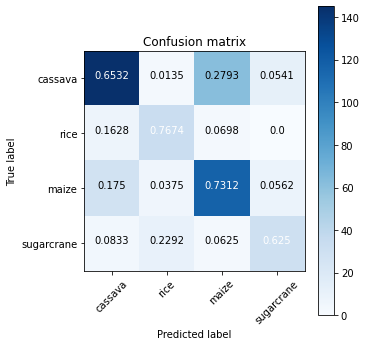

In [31]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')

# Downsample
# compute the confusion matrix
confusion_mtx = confusion_matrix(act_label , pred_label) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['cassava','rice','maize','sugarcrane'],normalize=True)
sum(act_label==pred_label)/len(act_label)

0.6871035940803383

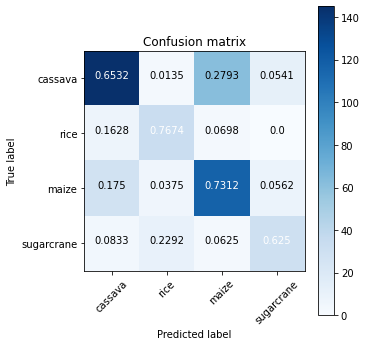

In [32]:
# Upsample
# compute the confusion matrix
confusion_mtx = confusion_matrix(act_label , pred_label) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['cassava','rice','maize','sugarcrane'],normalize=True)
sum(act_label==pred_label)/len(act_label)

0.6871035940803383

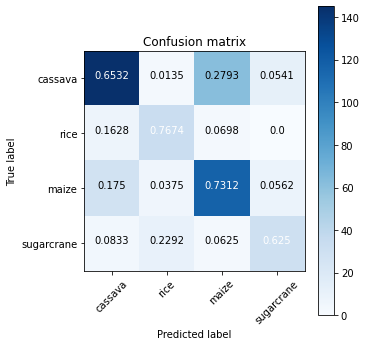

In [33]:
# Down Sampling
# compute the confusion matrix
confusion_mtx = confusion_matrix(act_label , pred_label) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['cassava','rice','maize','sugarcrane'],normalize=True)
sum(act_label==pred_label)/len(act_label)

In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(act_label, pred_label))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       222
           1       0.62      0.77      0.69        43
           2       0.63      0.73      0.68       160
           3       0.59      0.62      0.61        48

    accuracy                           0.69       473
   macro avg       0.66      0.69      0.67       473
weighted avg       0.70      0.69      0.69       473



## 03-Model Inference

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

# Ref: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py
# Install: pip install timm
import timm
from timm.models.efficientnet import default_cfgs 
from tensorboardX import SummaryWriter
import os
import shutil
import sys
import time
from glob import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
npy_path = sorted(glob("/content/training_data_5d/test/*.npy"))
df = pd.Series(npy_path,name="npy_path").to_frame()
# df['classes'] = df['npy_path'].apply(lambda x: int(x.split('.')[1][-1])-1)
# df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[2])
df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[3])
df

,npy_path,area_id
0,/content/training_data_5d/test/test_0000_000.npy,0000
1,/content/training_data_5d/test/test_0001_000.npy,0001
2,/content/training_data_5d/test/test_0002_000.npy,0002
3,/content/training_data_5d/test/test_0003_000.npy,0003
4,/content/training_data_5d/test/test_0004_000.npy,0004
...,...,...
12477,/content/training_data_5d/test/test_0564_179.npy,0564
12478,/content/training_data_5d/test/test_0564_180.npy,0564
12479,/content/training_data_5d/test/test_0564_181.npy,0564
12480,/content/training_data_5d/test/test_0564_182.npy,0564


In [38]:
# Dataset Loader
class SatDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.npy_path = list(df['npy_path'])
        self.area_id = list(df['area_id'])

    def __len__(self):
        return len(self.npy_path)
    def __getitem__(self, idx):
        data = np.load(self.npy_path[idx])
        # data = torch.from_numpy(np.swapaxes(data, -3, -1)).float()
        data = np.reshape(data, (-1,data.shape[2]))
        data = torch.from_numpy(np.swapaxes(data, 0, 1)).float()
        return {'image': data, 'area_id': self.area_id[idx]}

test_dataset = SatDataset(df)


# dataloaders
batch_size = 256
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
model = ClassifierModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/ARV_Varuna_Hackathon2022/checkpoint_1D/checkpoint/best_checkpoint.pth.tar')['state_dict'])
model.cuda().eval()

ClassifierModel(
  (backbone): Sequential(
    (0): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifi

In [40]:
pred_label = []
label_masks_score = []
area_ids = []
for batch in test_loader:
    batch_sz = batch['image'].shape[0]
    
    img = batch['image'].cuda()
    with torch.no_grad():
        logits = model(img).cpu().softmax(axis=1).numpy()
    pred_label += [logits]
    area_ids += batch['area_id']
    label_masks_score += [(img.cpu().numpy()!=0).reshape((batch_sz,-1)).sum(axis=1)/np.prod(batch['image'].shape[1:])]
pred_label = np.concatenate(pred_label)
label_masks_score = np.concatenate(label_masks_score)

In [41]:
pred_dict = dict()
for area_id,logit,mask_score in zip(area_ids,pred_label,label_masks_score):
    if area_id in pred_dict.keys():
        pred_dict[area_id] += mask_score*(logit)
    else:
        pred_dict[area_id] = mask_score*logit
pred_dict = {int(k):np.argmax(v) for k,v in pred_dict.items()}

In [42]:
df_output = pd.Series(pred_dict,name='crop_type').to_frame()
df_output['crop_type'] += 1
df_output

,crop_type
0,4
1,2
2,2
3,2
4,1
...,...
560,2
561,3
562,1
563,1


In [43]:
df_output.to_csv("/content/TheMoon_Conv1d_Pattareeya_Ver1.csv")

In [44]:
df_output['crop_type'].value_counts()

1    229
3    155
2    141
4     40
Name: crop_type, dtype: int64

## Predict in Validate

In [ ]:
df

,npy_path,area_id
0,/content/training_data_5d/test/test_0000_000.npy,0000
1,/content/training_data_5d/test/test_0001_000.npy,0001
2,/content/training_data_5d/test/test_0002_000.npy,0002
3,/content/training_data_5d/test/test_0003_000.npy,0003
4,/content/training_data_5d/test/test_0004_000.npy,0004
...,...,...
11811,/content/training_data_5d/test/test_0564_179.npy,0564
11812,/content/training_data_5d/test/test_0564_180.npy,0564
11813,/content/training_data_5d/test/test_0564_181.npy,0564
11814,/content/training_data_5d/test/test_0564_182.npy,0564


In [45]:
npy_path = sorted(glob("/content/training_data_5d/train/*.npy"))
df = pd.Series(npy_path,name="npy_path").to_frame()
df['classes'] = df['npy_path'].apply(lambda x: int(x.split('.')[0][-1])-1)
# df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[2])
df['area_id'] = df['npy_path'].apply(lambda x: x.split('_')[3])
df

,npy_path,classes,area_id
0,/content/training_data_5d/train/train_0000_000...,0,0000
1,/content/training_data_5d/train/train_0001_000...,0,0001
2,/content/training_data_5d/train/train_0001_001...,0,0001
3,/content/training_data_5d/train/train_0002_000...,0,0002
4,/content/training_data_5d/train/train_0002_001...,0,0002
...,...,...,...
5914,/content/training_data_5d/train/train_1315_000...,2,1315
5915,/content/training_data_5d/train/train_1316_000...,2,1316
5916,/content/training_data_5d/train/train_1316_001...,2,1316
5917,/content/training_data_5d/train/train_1316_002...,2,1316


In [46]:
train_id,test_id = train_test_split(df['area_id'].unique(), test_size=0.1, random_state=42)

# df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)
df_train = df.loc[[(i in train_id) for i in df['area_id']]]
df_val = df.loc[[(i in test_id) for i in df['area_id']]]

df_train.shape,df_val.shape

((5446, 3), (473, 3))

In [47]:
# Dataset Loader
class SatDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.npy_path = list(df['npy_path'])
        self.label = list(df['classes'])
        self.area_id = list(df['area_id'])

    def __len__(self):
        return len(self.npy_path)
    def __getitem__(self, idx):
        data = np.load(self.npy_path[idx])
        data = np.reshape(data, (-1,data.shape[2]))
        # data = torch.from_numpy(np.swapaxes(data, -3, -1)).float()
        data = torch.from_numpy(np.swapaxes(data, 0, 1)).float()
        return {'image': data, 'label': self.label[idx],'area_id':self.area_id[idx]}

val_dataset = SatDataset(df_val)
# dataloaders
batch_size = 256
test_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [48]:
pred_label = []
label_masks_score = []
area_ids = []

for batch in test_loader:
    batch_sz = batch['image'].shape[0]
    
    img = batch['image'].cuda()
    with torch.no_grad():
        logits = model(img).cpu().softmax(axis=1).numpy()
    pred_label += [logits]
    area_ids += batch['area_id']
    label_masks_score += [(img.cpu().numpy()!=0).reshape((batch_sz,-1)).sum(axis=1)/np.prod(batch['image'].shape[1:])]
pred_label = np.concatenate(pred_label)
label_masks_score = np.concatenate(label_masks_score)


In [49]:
pred_dict = dict()
for area_id,logit,mask_score in zip(area_ids,pred_label,label_masks_score):
    if area_id in pred_dict.keys():
        pred_dict[area_id] += mask_score*(logit)
    else:
        pred_dict[area_id] = mask_score*logit
pred_dict = {int(k):np.argmax(v) for k,v in pred_dict.items()}

In [50]:
df_val_res = pd.DataFrame([{int(i):j for i,j in zip(df_val.area_id,df_val.classes)},pred_dict],index = ['act_label','pred_label']).T
act_label = df_val_res.act_label.values
pred_label = df_val_res.pred_label.values
(act_label==pred_label).sum()/len(act_label)

0.6439393939393939

In [51]:
from sklearn.metrics import classification_report
print(classification_report(act_label, pred_label))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        60
           1       0.73      0.76      0.74        21
           2       0.55      0.70      0.62        37
           3       0.40      0.29      0.33        14

    accuracy                           0.64       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.65      0.64      0.64       132



In [ ]:
import shutil
shutil.move("/content/checkpoint", "/content/drive/MyDrive/ARV_Varuna_Hackathon2022/checkpoint_1D")

'/content/drive/MyDrive/ARV_Varuna_Hackathon2022/checkpoint_1D/checkpoint'